#### This is the CBOW implementation described in the word2vec paper

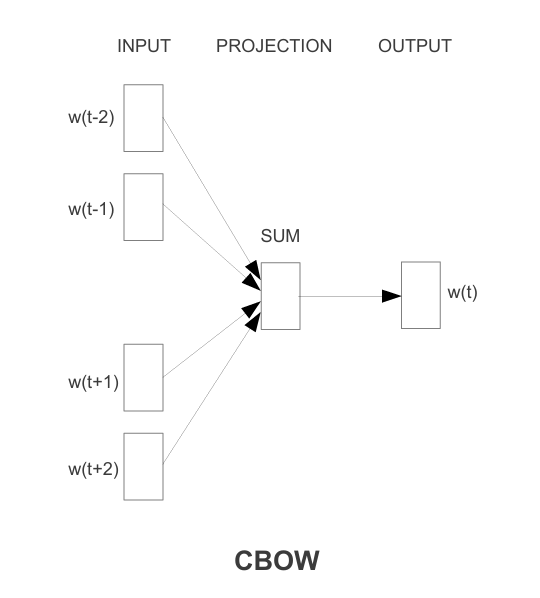

In [28]:
# basic installations
#!pip install torch transformers datasets

#### will be using [wikitext-v2](https://huggingface.co/datasets/Salesforce/wikitext/viewer/wikitext-2-v1) dataset from HF


In [2]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-v1", split="train[:20%]")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [3]:
dataset

Dataset({
    features: ['text'],
    num_rows: 7344
})

In [4]:
dataset[69]

{'text': ' The soldiers would be allowed safe passage in any direction carrying any personal and public property besides munitions of war . \n'}

In [5]:
train_text = " ".join(dataset["text"])
# train_text

#### cbow Model



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import numpy as np

class CBOW(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(CBOW, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear = nn.Linear(embedding_dim, vocab_size)

  def forward(self, context_words):
     # context-words - n words to left & n words to right
     context_embedding = torch.mean(self.embeddings(context_words), dim=1)
     # avg embedding of words used for overall contextual representation
     out = self.linear(context_embedding)
     return out

#### data preprocessing

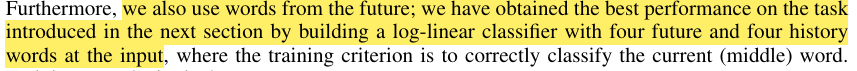

In [7]:
from collections import Counter

tokens = train_text.lower().split()

vocab_counter = Counter(tokens)
vocab = {word: idx for idx, (word, _) in enumerate(vocab_counter.most_common())}
idx_to_word = {idx: word for word, idx in vocab.items()}

encoded_tokens = [vocab[word] for word in tokens if word in vocab]

In [8]:
# generating training pairs
def create_cbow_data(corpus, window_size):
    data = []
    for i in range(window_size, len(corpus) - window_size):
        context = corpus[i - window_size:i] + corpus[i + 1:i + 1 + window_size]
        target = corpus[i]
        data.append((context, target))
    return data

In [9]:
data = create_cbow_data(encoded_tokens, window_size=3)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### hyperparameters

In [11]:
embedding_dim = 300
batch_size = 128
num_epochs = 100
learning_rate = 7e-4

In [12]:
def generate_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]

        # Ensure all context lists have the same length
        context, target = zip(*batch)
        max_context_len = max(len(c) for c in context)

        # Pad contexts to the same length
        padded_context = [
            c + [0] * (max_context_len - len(c)) for c in context
        ]

        yield torch.tensor(padded_context, dtype=torch.long, device=device), torch.tensor(target, dtype=torch.long, device=device)
        # yield -> used to create a generator function

In [13]:
vocab_size = len(vocab)
model = CBOW(vocab_size, embedding_dim).to(device)
model

CBOW(
  (embeddings): Embedding(18512, 300)
  (linear): Linear(in_features=300, out_features=18512, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### training

In [15]:
for epoch in range(num_epochs):
    total_loss = 0
    for context_batch, target_batch in generate_batches(data, batch_size):
        optimizer.zero_grad()
        output = model(context_batch)
        loss = criterion(output, target_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/100, Loss: 22343.7581
Epoch 2/100, Loss: 18724.8912
Epoch 3/100, Loss: 17099.0634
Epoch 4/100, Loss: 15850.5607
Epoch 5/100, Loss: 14793.1160
Epoch 6/100, Loss: 13867.4935
Epoch 7/100, Loss: 13050.5141
Epoch 8/100, Loss: 12330.0476
Epoch 9/100, Loss: 11692.0709
Epoch 10/100, Loss: 11120.0428
Epoch 11/100, Loss: 10604.0132
Epoch 12/100, Loss: 10132.2668
Epoch 13/100, Loss: 9699.8382
Epoch 14/100, Loss: 9299.6084
Epoch 15/100, Loss: 8928.4667
Epoch 16/100, Loss: 8581.4943
Epoch 17/100, Loss: 8257.2683
Epoch 18/100, Loss: 7952.0051
Epoch 19/100, Loss: 7665.6213
Epoch 20/100, Loss: 7394.6078
Epoch 21/100, Loss: 7139.6303
Epoch 22/100, Loss: 6897.8934
Epoch 23/100, Loss: 6669.0769
Epoch 24/100, Loss: 6452.5999
Epoch 25/100, Loss: 6247.7710
Epoch 26/100, Loss: 6053.0141
Epoch 27/100, Loss: 5869.1829
Epoch 28/100, Loss: 5694.3432
Epoch 29/100, Loss: 5529.1595
Epoch 30/100, Loss: 5371.9823
Epoch 31/100, Loss: 5223.6914
Epoch 32/100, Loss: 5082.5939
Epoch 33/100, Loss: 4949.4298
Epoch 3

In [16]:
# Save embeddings
torch.save(model.embeddings.weight.data, "cbow_embeddings.pth")

In [17]:
def get_embedding(word):
    word_idx = vocab.get(word, None)
    if word_idx is not None:
        return model.embeddings.weight.data[word_idx]
    else:
        print("Word not in vocabulary")
        return None

get_embedding('biggest')

tensor([ 1.1476e+00, -2.9134e+00, -1.1653e+00,  4.5646e-01,  2.0097e+00,
         6.2346e-01,  1.0001e+00, -7.4594e-01, -2.8646e-03,  2.6844e+00,
         1.2325e+00,  1.3683e+00, -6.0224e-01,  1.2934e+00,  1.3045e+00,
        -1.2458e+00, -4.1953e-01, -4.0103e-02,  8.7735e-01, -2.3445e+00,
        -9.8909e-01,  1.6473e+00,  8.6674e-01,  1.0572e+00,  2.6070e+00,
        -1.6356e+00,  1.1600e+00, -1.3597e+00,  2.4171e+00,  8.8165e-01,
         8.2663e-01, -2.2128e-01,  2.5902e+00,  2.8865e-01, -9.5545e-01,
         9.9316e-01,  8.2742e-01, -2.6803e+00,  3.5744e+00, -2.8339e+00,
         4.4279e-01,  7.4011e-01, -1.2389e+00,  7.7171e-01, -9.5072e-02,
        -5.7646e-02,  2.1061e+00,  1.8363e+00, -1.4224e+00, -2.2184e+00,
         2.8978e-01, -5.3232e-01,  2.8936e+00, -4.8522e-01,  2.1265e+00,
         7.4770e-01, -2.3925e-01, -8.3464e-01, -1.8507e+00, -3.6571e+00,
        -5.1236e-01,  1.2882e-02, -1.3417e-01,  1.5007e+00,  1.4433e+00,
         4.2363e-01,  3.7198e+00,  2.9599e+00,  4.8

#### visualizing using t-SNE

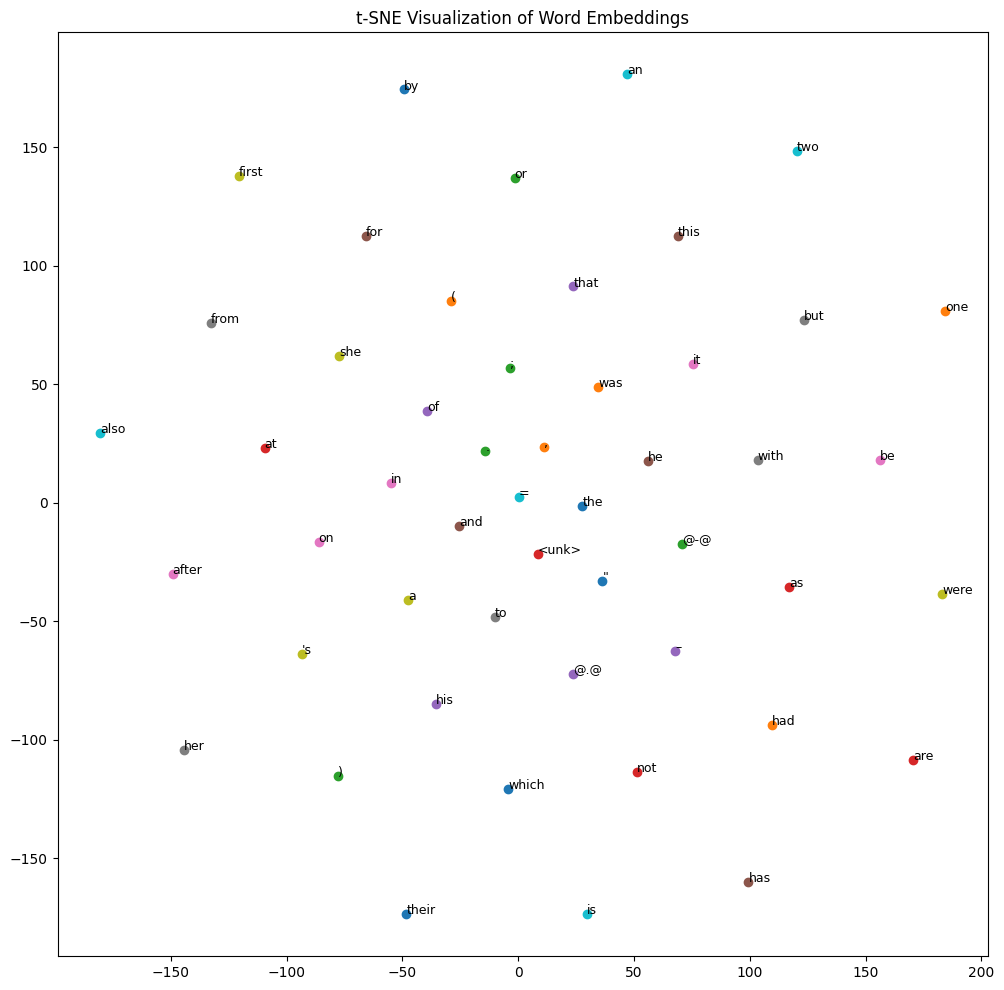

In [22]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings = model.embeddings.weight.data

words_to_visualize = 50
selected_embeddings = embeddings[:words_to_visualize].cpu()
labels = [idx_to_word[i] for i in range(words_to_visualize)]

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
reduced_embeddings = tsne.fit_transform(selected_embeddings)

plt.figure(figsize=(12, 12))
for i, label in enumerate(labels):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)
plt.title("t-SNE Visualization of Word Embeddings")
plt.show()

#### todo - testing on this as given in the paper

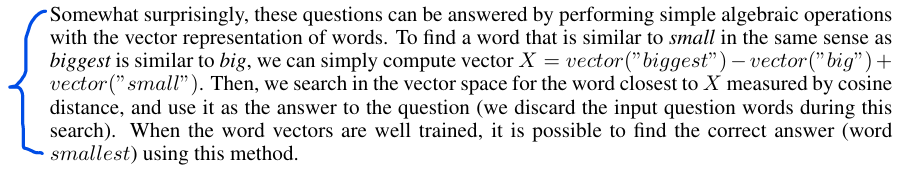